In [1]:
# ref https://www.kaggle.com/code/hojjatk/read-mnist-dataset

#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [2]:
training_images_filepath = 'mnist-dataset/train-images.idx3-ubyte'
training_labels_filepath = 'mnist-dataset/train-labels.idx1-ubyte'
test_images_filepath = 'mnist-dataset/t10k-images.idx3-ubyte'
test_labels_filepath = 'mnist-dataset/t10k-labels.idx1-ubyte'

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

x_train = np.array(x_train).reshape(-1, 784) / 255.0  # flatten 28x28 to 784 and normalize
x_test = np.array(x_test).reshape(-1, 784) / 255.0
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long) 

train_ds = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 32), # 28 * 28 = 784
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10),  # output 10 classes (0-9 digits)
        )

    def forward(self, x):
        return self.net(x)

model = MNISTModel()

criterion = nn.CrossEntropyLoss()          
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [4]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, loss = {epoch_loss:.4f}")

Epoch 10/100, loss = 0.0796
Epoch 20/100, loss = 0.0439
Epoch 30/100, loss = 0.0264
Epoch 40/100, loss = 0.0192
Epoch 50/100, loss = 0.0174
Epoch 60/100, loss = 0.0141
Epoch 70/100, loss = 0.0110
Epoch 80/100, loss = 0.0089
Epoch 90/100, loss = 0.0099
Epoch 100/100, loss = 0.0110


In [5]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    outputs = model(x_test_tensor)
    _, predicted = torch.max(outputs, 1) 
    
    total = y_test_tensor.size(0)
    correct = (predicted == y_test_tensor).sum().item()
    accuracy = 100 * correct / total
    
    print(f'Test Accuracy: {accuracy:.2f}% ({correct}/{total} correct)')
    

Test Accuracy: 97.02% (9702/10000 correct)


Total misclassified: 298 out of 10000

Showing 10 misclassified examples:



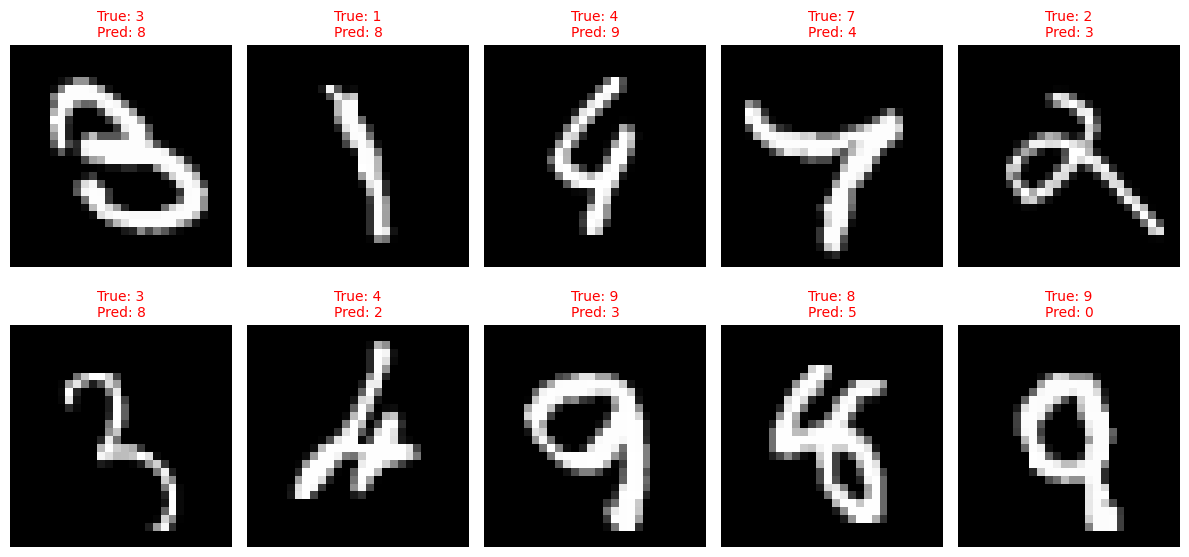

In [8]:
import matplotlib.pyplot as plt

# find misclassified examples
misclassified_indices = (predicted != y_test_tensor).nonzero(as_tuple=True)[0]
num_to_show = min(10, len(misclassified_indices))  # show up to 10 examples

print(f'Total misclassified: {len(misclassified_indices)} out of {total}')
print(f'\nShowing {num_to_show} misclassified examples:\n')

# create a figure with subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i in range(num_to_show):
    idx = misclassified_indices[i].item()
    
    # reshape the flattened image back to 28x28
    img = x_test[idx].reshape(28, 28)
    
    # display the image
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'True: {y_test[idx]}\nPred: {predicted[idx].item()}', 
                     color='red', fontsize=10)

plt.tight_layout()
plt.show()